In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
x, y, h = symbols(r'x, y, h', real=True)
u = symbols('u', cls=Function)(x, y)

In [3]:
pda_f, pda_v = (u,), (x, y)
pda_n, pda_clp = 7, 5
pda_p = Rational(0, 1), Rational(0, 1)

In [4]:
Monom.variables = 1 + len(pda_v)
Monom.cmp = Monom.TOPdeglex
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [5]:
def T(f, j1, k1):
    return sum(sum(\
        diff(f, x, j, y, k)*(h*(j1+pda_p[0]))**j
                           *(h*(k1+pda_p[1]))**k/\
               (factorial(j)*factorial(k))\
               for k in range(pda_n-j)) for j in range(pda_n))

In [6]:
def clip(f):
    f = f.expand()
    return [f.coeff(h, i) for i in range(pda_clp)]

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def reduction(f1, f2, m, c, shift):
    assert shift < pda_clp
    r = [f1[i] for i in range(shift)]
    if not m:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift]*c))
    else:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift].diff(*m)*c))
    return r

def NF(f, df, G, trace=False):
    assert len(df) == len(G)
#     print(df2m(df[0]))
    ms = [df2m(d) for d in df]
    for i in range(1, pda_clp):
        t = 0
        if f[i]:
            while True:
                r = None
                for l in range(len(ms)):
                    r = findDiv(f[i], ms[l])
                    if r:
                        break
                if not r: 
                    break
                c, deg, m = 0, 7, m2df(r)
                while c == 0:
                    c = f[i].coeff(m, deg)
                    deg -= 1
                    assert deg >= 0
#                 print(c, m, deg+1)
                if deg:
                    c *= m**deg
                m = r/ms[l]
                d = []
                for k in range(len(pda_v)):
                    if m[k+1] > 0:
                        d.append(pda_v[k])
                        if m[k+1] > 1:
                            d.append(m[k+1])
                if trace:
                    print(">"*12)
                    eq = Symbol("eq%d" % (l+1), real=True)
                    if d:
                        display(Derivative(*tuple([eq] + d))*c*h**i)
                    else:
                        display(eq*c*h**i)
                f = reduction(f, G[l], tuple(d), c, i)
                if trace:
                    print("res =")
                    display(f)
                    print("<"*12)
                t += 1
#                 if t > 6: break
    return f

# difference scheme (55) #
\begin{equation}
\left\{
\begin{gathered}
\dfrac{u_{j+1\,k}-u_{j\,k}}{h_1} - u_{j\,k}^2 = 0 , \\
\dfrac{u_{j\,k+1}-u_{j\,k}}{h_2} + u_{j\,k}^2 = 0 .
\end{gathered}
\right.
\end{equation}

In [7]:
pda_p = Rational(0, 1), Rational(0, 1)

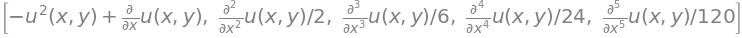

In [8]:
eq1 = clip((T(u, 1, 0) - T(u, 0, 0))/h - T(u**2, 0, 0))
eq1

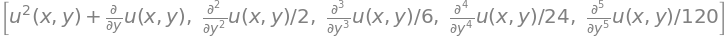

In [9]:
eq2 = clip((T(u, 0, 1) - T(u, 0, 0))/h + T(u**2, 0, 0))
eq2

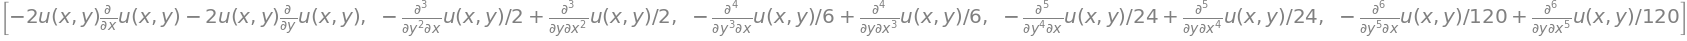

In [10]:
spoly = [eq1[i].diff(y) - eq2[i].diff(x) for i in range(pda_clp)]
spoly

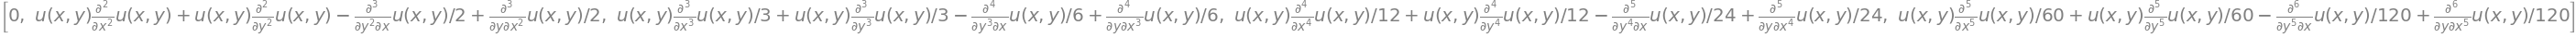

In [11]:
spoly = reduction(spoly, eq1, (), -2*u, 0)
spoly = reduction(spoly, eq2, (), -2*u, 0)
spoly

In [12]:
NF(spoly, [u.diff(x), u.diff(y)], [eq1, eq2])

# difference scheme (56) #
\begin{equation}
\left\{
\begin{gathered}
\dfrac{u_{j+1\,k}-u_{j\,k}}{h_1} - u_{j\,k}^2 = 0 , \\
\dfrac{u_{j\,k+1}-u_{j\,k}}{h_2} + u_{j\,k+1}^2 = 0 .
\end{gathered}
\right.
\end{equation}

In [13]:
pda_p = Rational(0, 1), Rational(0, 1)

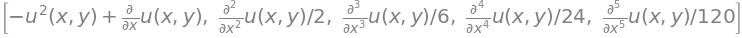

In [14]:
eq1 = clip((T(u, 1, 0) - T(u, 0, 0))/h - T(u**2, 0, 0))
eq1

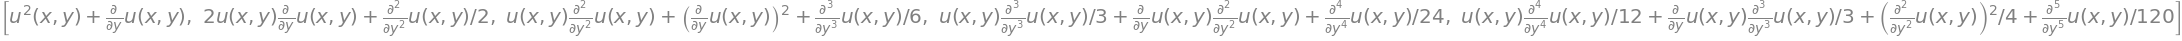

In [15]:
eq2 = clip((T(u, 0, 1) - T(u, 0, 0))/h + T(u**2, 0, 1))
eq2

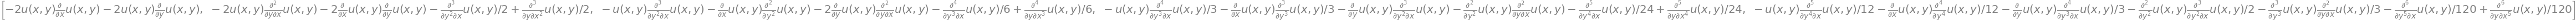

In [16]:
spoly = [eq1[i].diff(y) - eq2[i].diff(x) for i in range(pda_clp)]
spoly

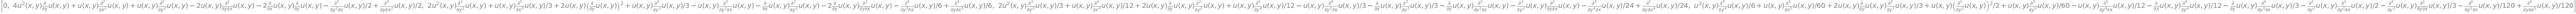

In [17]:
spoly = reduction(spoly, eq1, (), -2*u, 0)
spoly = reduction(spoly, eq2, (), -2*u, 0)
spoly

In [18]:
NF(spoly, [u.diff(x), u.diff(y)], [eq1, eq2])

>>>>>>>>>>>>


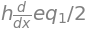

res =


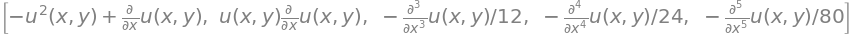

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


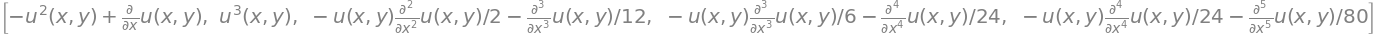

<<<<<<<<<<<<
>>>>>>>>>>>>


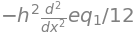

res =


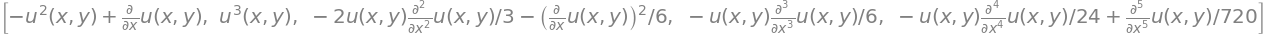

<<<<<<<<<<<<
>>>>>>>>>>>>


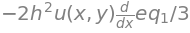

res =


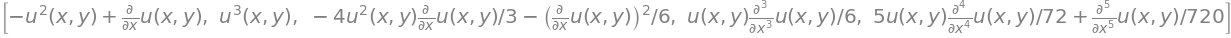

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


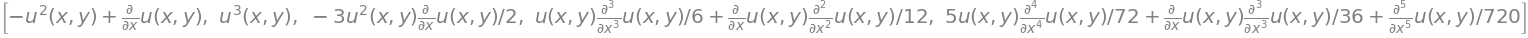

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


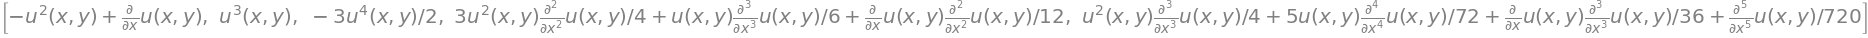

<<<<<<<<<<<<
>>>>>>>>>>>>


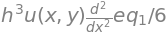

res =


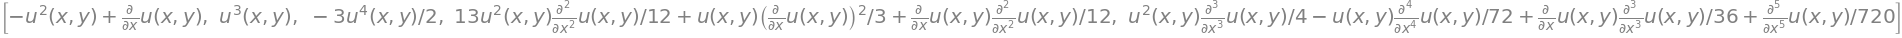

<<<<<<<<<<<<
>>>>>>>>>>>>


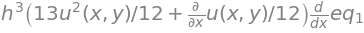

res =


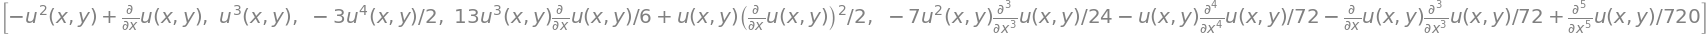

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


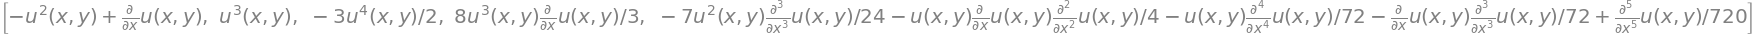

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


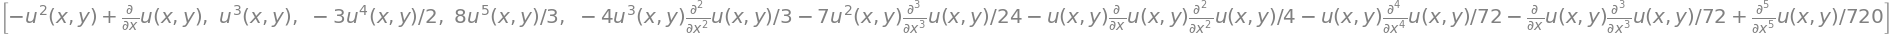

<<<<<<<<<<<<
>>>>>>>>>>>>


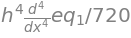

res =


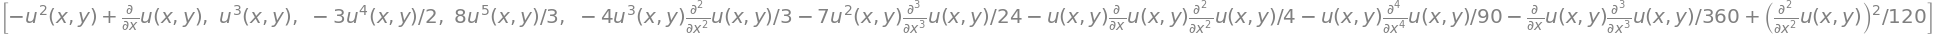

<<<<<<<<<<<<
>>>>>>>>>>>>


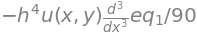

res =


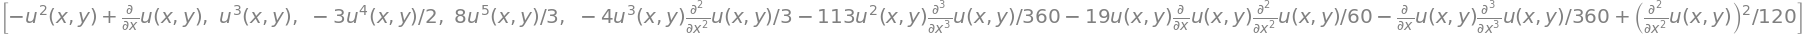

<<<<<<<<<<<<
>>>>>>>>>>>>


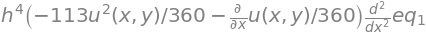

res =


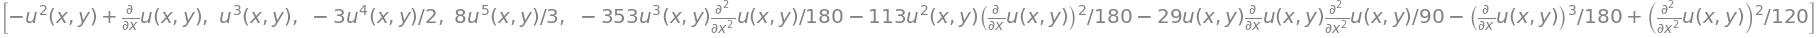

<<<<<<<<<<<<
>>>>>>>>>>>>


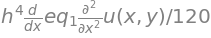

res =


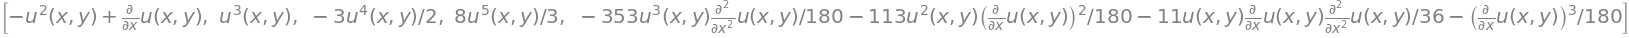

<<<<<<<<<<<<
>>>>>>>>>>>>


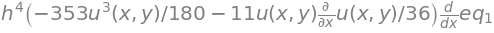

res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<


In [19]:
NF(eq1, [u.diff(x), u.diff(y)], [eq1, eq2], trace=True)

>>>>>>>>>>>>


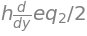

res =


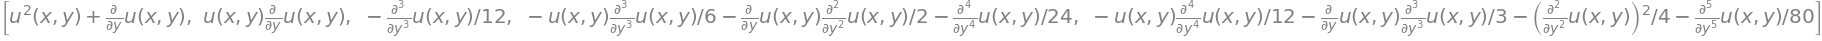

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


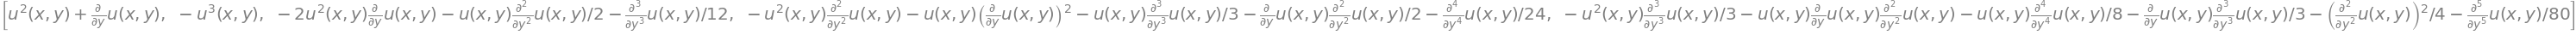

<<<<<<<<<<<<
>>>>>>>>>>>>


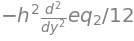

res =


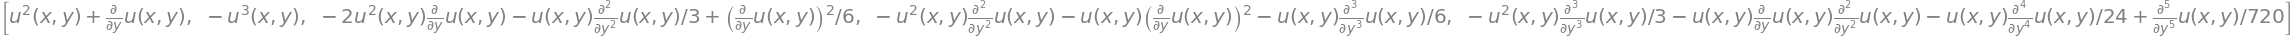

<<<<<<<<<<<<
>>>>>>>>>>>>


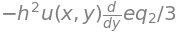

res =


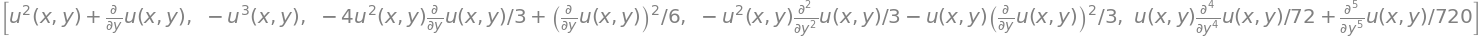

<<<<<<<<<<<<
>>>>>>>>>>>>


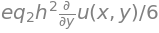

res =


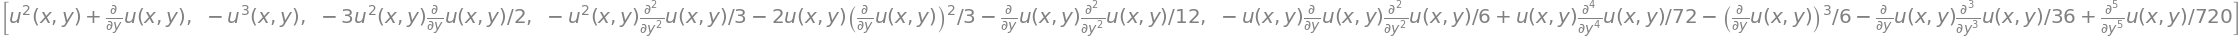

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


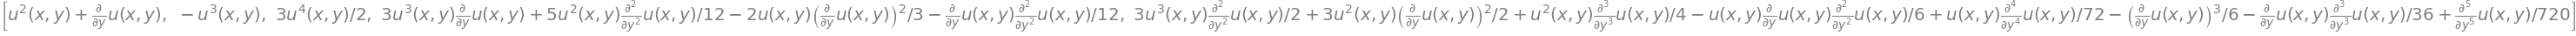

<<<<<<<<<<<<
>>>>>>>>>>>>


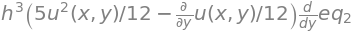

res =


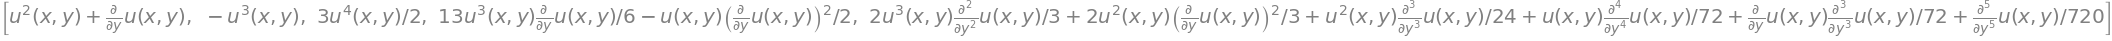

<<<<<<<<<<<<
>>>>>>>>>>>>


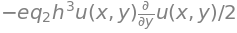

res =


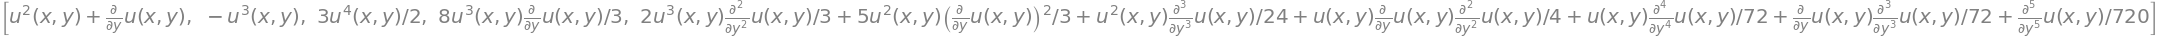

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


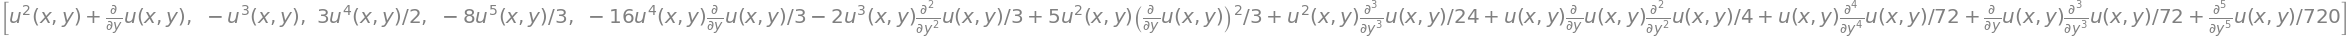

<<<<<<<<<<<<
>>>>>>>>>>>>


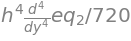

res =


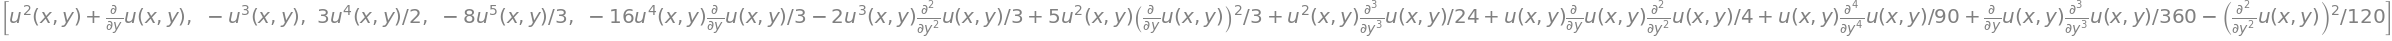

<<<<<<<<<<<<
>>>>>>>>>>>>


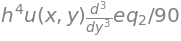

res =


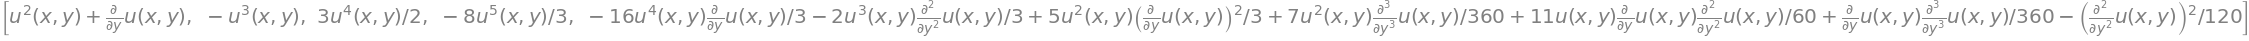

<<<<<<<<<<<<
>>>>>>>>>>>>


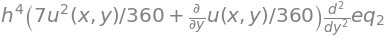

res =


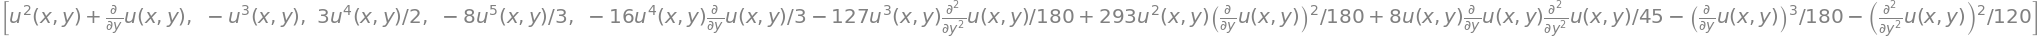

<<<<<<<<<<<<
>>>>>>>>>>>>


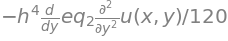

res =


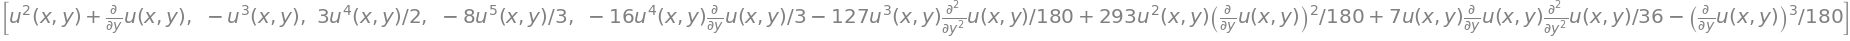

<<<<<<<<<<<<
>>>>>>>>>>>>


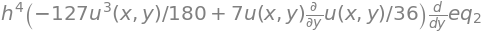

res =


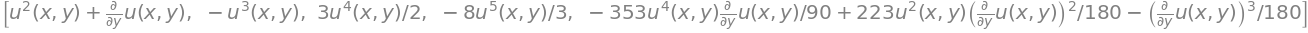

<<<<<<<<<<<<
>>>>>>>>>>>>


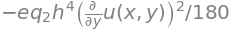

res =


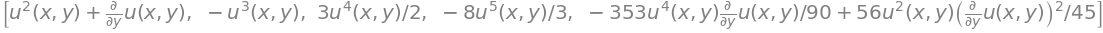

<<<<<<<<<<<<
>>>>>>>>>>>>


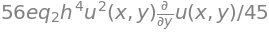

res =


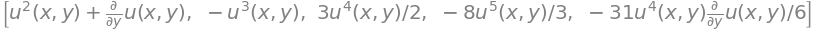

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


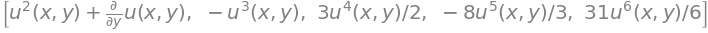

<<<<<<<<<<<<


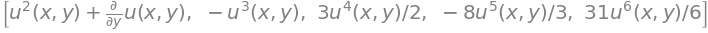

In [20]:
NF(eq2, [u.diff(x), u.diff(y)], [eq1, eq2], trace=True)

# difference scheme (57) #
\begin{equation}
\left\{
\begin{gathered}
\dfrac{u_{j+2\,k}-u_{j\,k}}{2h_1} - u_{j+1\,k}^2 = 0 , \\
\dfrac{u_{j\,k+2}-u_{j\,k}}{2h_2} + u_{j\,k+1}^2 = 0 .
\end{gathered}
\right.
\end{equation}

In [21]:
pda_p = Rational(0, 1), Rational(0, 1)

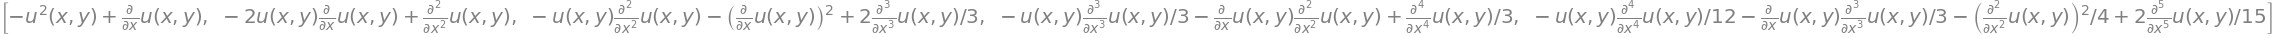

In [22]:
eq1 = clip((T(u, 2, 0) - T(u, 0, 0))/(2*h) - T(u**2, 1, 0))
eq1

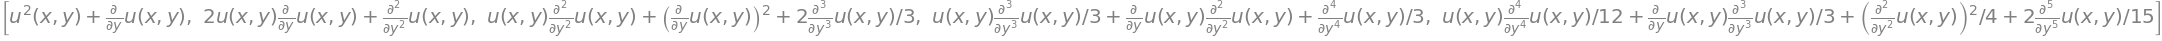

In [23]:
eq2 = clip((T(u, 0, 2) - T(u, 0, 0))/(2*h) + T(u**2, 0, 1))
eq2

>>>>>>>>>>>>


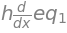

res =


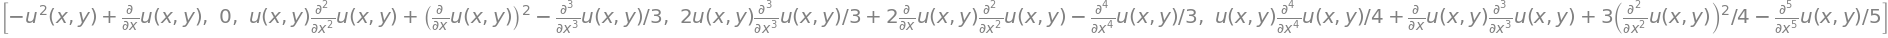

<<<<<<<<<<<<
>>>>>>>>>>>>


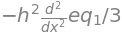

res =


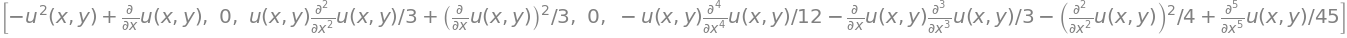

<<<<<<<<<<<<
>>>>>>>>>>>>


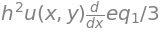

res =


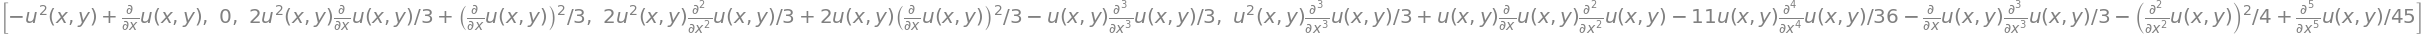

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


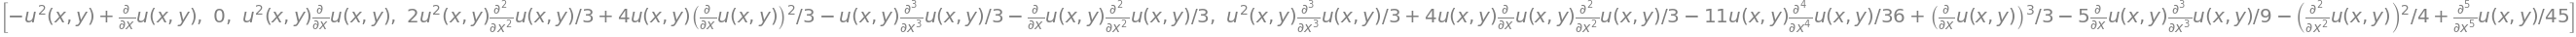

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


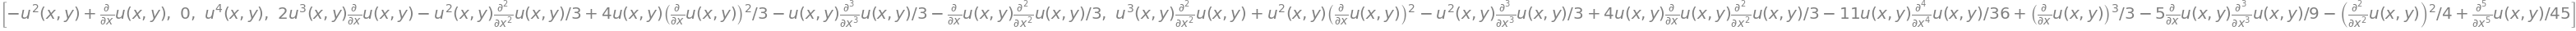

<<<<<<<<<<<<
>>>>>>>>>>>>


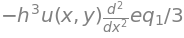

res =


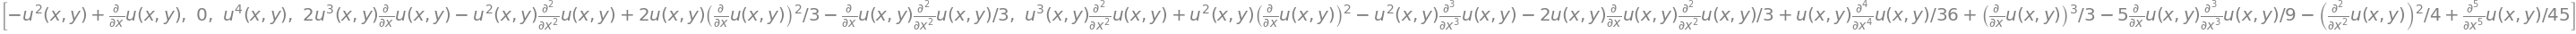

<<<<<<<<<<<<
>>>>>>>>>>>>


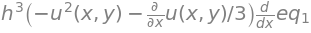

res =


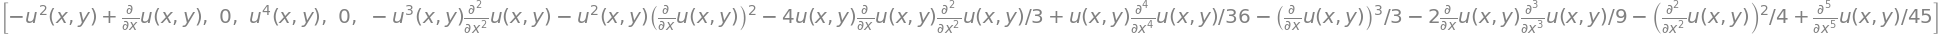

<<<<<<<<<<<<
>>>>>>>>>>>>


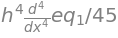

res =


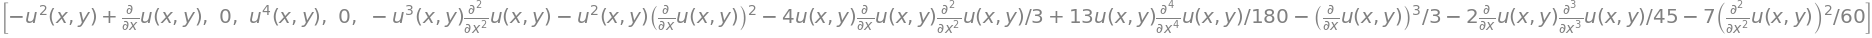

<<<<<<<<<<<<
>>>>>>>>>>>>


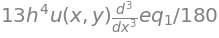

res =


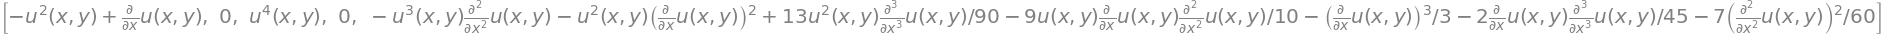

<<<<<<<<<<<<
>>>>>>>>>>>>


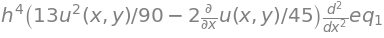

res =


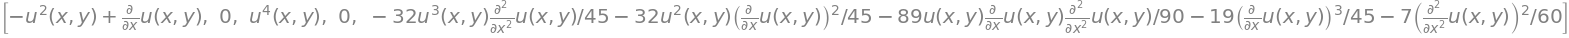

<<<<<<<<<<<<
>>>>>>>>>>>>


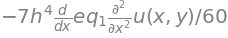

res =


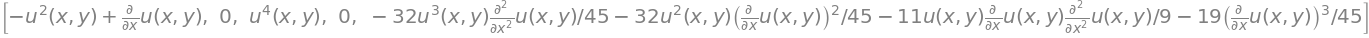

<<<<<<<<<<<<
>>>>>>>>>>>>


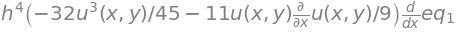

res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<
>>>>>>>>>>>>


res =


<<<<<<<<<<<<


In [24]:
eq1PDA = NF(eq1, [u.diff(x), u.diff(y)], [eq1, eq2], trace=True)
eq1PDA

>>>>>>>>>>>>


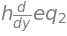

res =


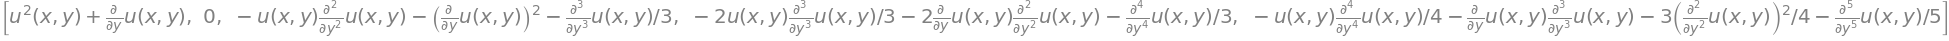

<<<<<<<<<<<<
>>>>>>>>>>>>


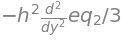

res =


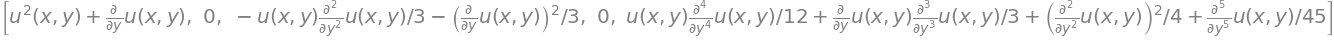

<<<<<<<<<<<<
>>>>>>>>>>>>


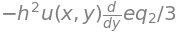

res =


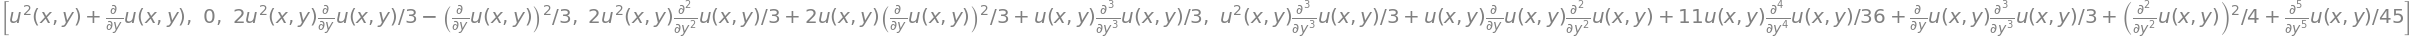

<<<<<<<<<<<<
>>>>>>>>>>>>


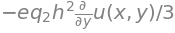

res =


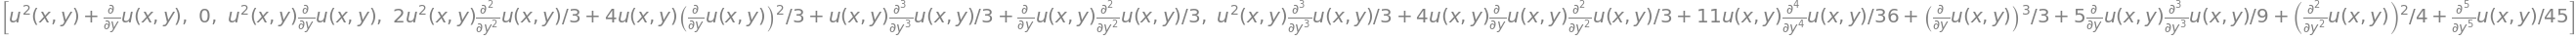

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


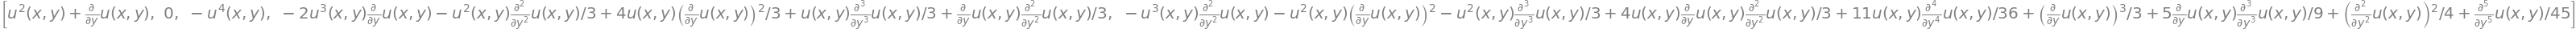

<<<<<<<<<<<<
>>>>>>>>>>>>


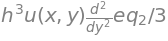

res =


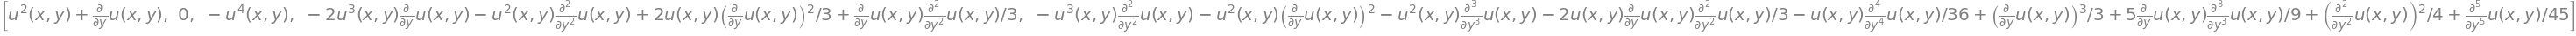

<<<<<<<<<<<<
>>>>>>>>>>>>


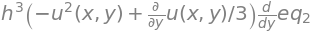

res =


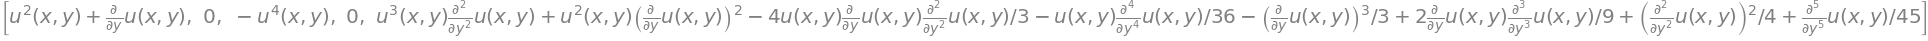

<<<<<<<<<<<<
>>>>>>>>>>>>


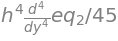

res =


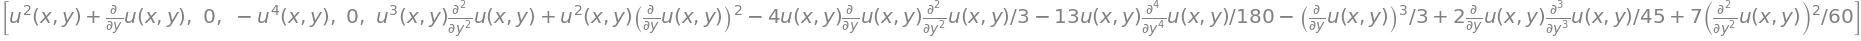

<<<<<<<<<<<<
>>>>>>>>>>>>


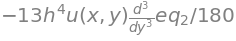

res =


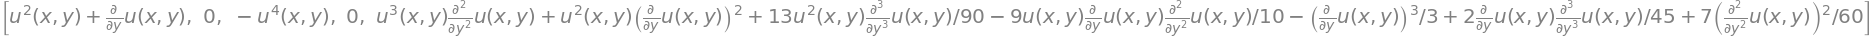

<<<<<<<<<<<<
>>>>>>>>>>>>


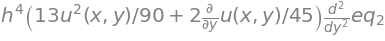

res =


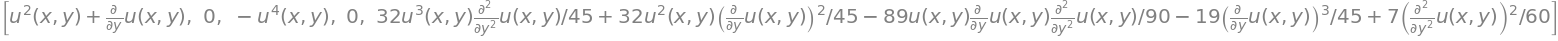

<<<<<<<<<<<<
>>>>>>>>>>>>


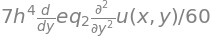

res =


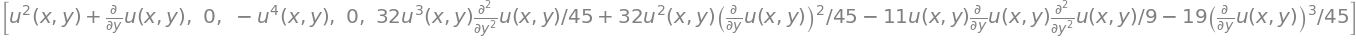

<<<<<<<<<<<<
>>>>>>>>>>>>


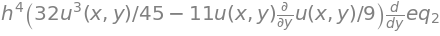

res =


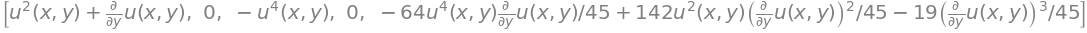

<<<<<<<<<<<<
>>>>>>>>>>>>


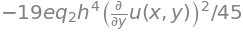

res =


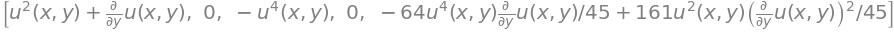

<<<<<<<<<<<<
>>>>>>>>>>>>


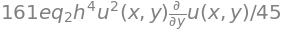

res =


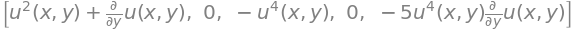

<<<<<<<<<<<<
>>>>>>>>>>>>


res =


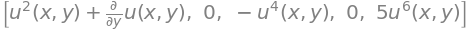

<<<<<<<<<<<<


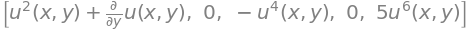

In [25]:
eq2PDA = NF(eq2, [u.diff(x), u.diff(y)], [eq1, eq2], trace=True)
eq2PDA

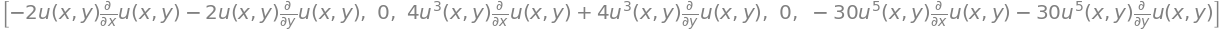

In [26]:
spoly = [eq1PDA[i].diff(y) - eq2PDA[i].diff(x) for i in range(pda_clp)]
spoly

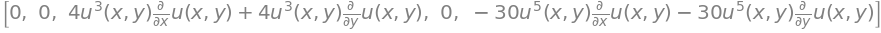

In [27]:
spoly = reduction(spoly, eq1PDA, (), -2*u, 0)
spoly = reduction(spoly, eq2PDA, (), -2*u, 0)
spoly

In [28]:
NF(spoly, [u.diff(x), u.diff(y)], [eq1PDA, eq2PDA])